# EXTRACT

In [2]:
# Импортирование необходимых для работы библиотек
import pandas as pd
import sqlite3

In [3]:
# Читаем CSV файл
df = pd.read_csv("trades (1).csv", parse_dates=["timestamp"])

# TRANSFORM

In [5]:
# Перед тем, как приступить к этапу "Transform" проведем небольшой EDA, что бы понимать с какими данными работаем
print(f"Количество строк, колонок: {df.shape}")
print(f"Название колонок: {df.columns.tolist()}")

Количество строк, колонок: (800, 7)
Название колонок: ['timestamp', 'user_id', 'client_type', 'symbol', 'side', 'quantity', 'price']


In [6]:
# Посмотрим на первые и последние 5 строк самих данных
df

,timestamp,user_id,client_type,symbol,side,quantity,price
0,2023-03-17 14:24:00,1001,gold,AAPL,buy,7.67,157.35
1,2023-02-23 07:31:00,1001,gold,AAPL,buy,1.84,156.98
2,2023-02-13 03:29:00,1001,gold,SPY,sell,8.28,417.01
3,2023-02-18 02:41:00,1001,gold,AAPL,sell,1.87,175.42
4,2023-01-30 09:52:00,1001,gold,QQQ,sell,8.46,351.83
...,...,...,...,...,...,...,...
795,2023-02-26 00:19:00,3005,bronze,MSFT,sell,2.59,280.34
796,2023-01-29 07:59:00,3005,bronze,GOOGL,buy,7.83,2712.76
797,2023-03-23 13:31:00,3005,bronze,SPY,sell,1.33,400.36
798,2023-03-14 05:59:00,3005,bronze,AAPL,sell,6.12,164.82


In [7]:
df.describe()

,user_id,quantity,price
count,800.000000,795.000000,795.000000
mean,1995.522500,5.490302,749.079560
std,820.550258,2.577035,919.318597
min,1001.000000,1.040000,150.020000
25%,1004.000000,3.200000,287.345000
50%,2003.000000,5.570000,366.110000
75%,3002.000000,7.715000,433.800000
max,3005.000000,9.990000,2796.650000


In [8]:
# Проверяем есть ли Null Values
df.isnull().values.any()

True

In [9]:
# Смотрим количество Null Values
df.isnull().sum()

timestamp      5
user_id        0
client_type    0
symbol         5
side           0
quantity       5
price          5
dtype: int64

In [10]:
# Посмотрим Null Values "по ближе"
print(df[df.isnull().any(axis=1)])

      timestamp  user_id client_type symbol  side  quantity  price
293         NaN     2001      silver   MSFT   buy       1.5  300.0
294  not_a_date     2001      silver    NaN  sell       NaN    NaN
339         NaN     2002      silver   MSFT   buy       1.5  300.0
340  not_a_date     2002      silver    NaN  sell       NaN    NaN
381         NaN     2003      silver   MSFT   buy       1.5  300.0
382  not_a_date     2003      silver    NaN  sell       NaN    NaN
443         NaN     2004      silver   MSFT   buy       1.5  300.0
444  not_a_date     2004      silver    NaN  sell       NaN    NaN
493         NaN     2005      silver   MSFT   buy       1.5  300.0
494  not_a_date     2005      silver    NaN  sell       NaN    NaN


In [11]:
# not_a_date? Сколько таких случаев?
count_not_a_date = (df["timestamp"] == "not_a_date").sum()
print(count_not_a_date)

5


### Прежде чем приняти решение, что делать с Null Values следут посмотреть какую важность они имеют для проведения анализа

In [13]:
# Создаем маску строк, где есть хотя бы один Null Value
mask = df[["timestamp", "symbol", "quantity", "price"]].isna().any(axis=1)
# Строки с null
null_rows = df[mask]

# Обсчитываем общее количество строк на каждого пользователя
total_per_user = df.groupby("user_id").size().reset_index(name="total_rows")

# Обсчитываем количество строк с Null Value на user_id
null_per_user = null_rows.groupby("user_id").size().reset_index(name="null_rows")

# Объединяем
report = total_per_user.merge(null_per_user, on="user_id", how="left").fillna(0)

# Добавляем % Null Values
report["null_percent"] = (report["null_rows"] / report["total_rows"] * 100).round(2)

print(report)

    user_id  total_rows  null_rows  null_percent
0      1001          60        0.0          0.00
1      1002          51        0.0          0.00
2      1003          57        0.0          0.00
3      1004          51        0.0          0.00
4      1005          53        0.0          0.00
5      2001          46        2.0          4.35
6      2002          42        2.0          4.76
7      2003          62        2.0          3.23
8      2004          50        2.0          4.00
9      2005          62        2.0          3.23
10     3001          55        0.0          0.00
11     3002          53        0.0          0.00
12     3003          54        0.0          0.00
13     3004          53        0.0          0.00
14     3005          51        0.0          0.00


### Мы видим, что Null Values присутствуют только у user_id со значением 2001 - 2005 (включительно), то есть под влиянием Null Values оказываються 5 из 15 пользователей, что составляет 30% всех пользователей
Для принятия финального решения стоит посчитать общее количество Null Values и их % от всех значений, что бы определить их влияние на весь dataset

In [15]:
# Обсчитываем общее количество значений (строки × колонки)
total_values = df.size  

# Обсчитываем общее количество Null Values
null_values = df.isna().sum().sum()

# Обсчитываем % Null Values от всех значений
null_percent = round(null_values / total_values * 100, 2)

print(f"Всего значений: {total_values}")
print(f"Null Values: {null_values}")
print(f"Доля Null Values: {null_percent}%")

Всего значений: 5600
Null Values: 20
Доля Null Values: 0.36%


In [16]:
# Учитывая, низкое значение доли Null Values (0.36%) и тот факт, что это тестовое задание - в этот раз мы просто избавимся от строк, в которых есть Null Values
df = df.dropna()

In [17]:
# Проверяем кейс not_a_date
count_not_a_date = (df["timestamp"] == "not_a_date").sum()
print(count_not_a_date)

0


In [18]:
# Double-checking
print(df[df.isnull().any(axis=1)])

Empty DataFrame
Columns: [timestamp, user_id, client_type, symbol, side, quantity, price]
Index: []


In [19]:
# Double-checking
df.isnull().sum()

timestamp      0
user_id        0
client_type    0
symbol         0
side           0
quantity       0
price          0
dtype: int64

In [20]:
# Проверяем на предмет наличия дубликатов
df.duplicated().sum()

0

In [21]:
# Проверяем правильность форматов
df.dtypes

timestamp       object
user_id          int64
client_type     object
symbol          object
side            object
quantity       float64
price          float64
dtype: object

In [22]:
# Делаем копию
df = df.copy()

In [23]:
# Проставляем соответсвующие форматы + нормализируем
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["client_type"] = df["client_type"].astype("string").str.lower().str.strip()
df["symbol"] = df["symbol"].astype("string").str.upper().str.strip()
df["side"] = df["side"].astype("string").str.lower().str.strip()

In [24]:
# Double-checking
df.dtypes

timestamp      datetime64[ns]
user_id                 int64
client_type    string[python]
symbol         string[python]
side           string[python]
quantity              float64
price                 float64
dtype: object

### Преобразование timestamp в week_start_date (понедельник)

In [26]:
# Преобразование timestamp в week_start_date (понедельник)
df["week_start_date"] = df["timestamp"].dt.to_period("W-MON").dt.start_time

### Агрегируйте данные по: week_start_date client_type (gold, silver, bronze) user_id symbol

In [28]:
# Прежде чем переходить к агрегации данних проверяем какие значения есть в колонке "client_type" и есть ли необходимось фильтровать (gold, silver, bronze)
df["client_type"].value_counts()

client_type
gold      272
bronze    266
silver    252
Name: count, dtype: Int64

In [29]:
# Посколько иных значений от (gold, silver, bronze) в колонке "client_type" нет - переходим к агрегации
# Добавляем колонку с расчетом pnl
df["pnl"] = df.apply(lambda r: r["quantity"] * r["price"] * (1 if r["side"].lower()=="sell" else -1), axis=1)

In [30]:
# Выполняем агрегацию с рассчитыванием total_volume, total_pnl, trade_count
agg = (
    df.groupby(["week_start_date", "client_type", "user_id", "symbol"])
      .agg(
          total_volume=("quantity", "sum"),
          total_pnl=("pnl", "sum"),
          trade_count=("user_id", "count")
      )
      .reset_index()
)

In [31]:
# Посмотрим на первые и последние 5 строк
agg

,week_start_date,client_type,user_id,symbol,total_volume,total_pnl,trade_count
0,2022-12-27,bronze,3002,GOOGL,8.12,-21216.2608,1
1,2022-12-27,bronze,3004,AAPL,6.56,1102.1456,1
2,2022-12-27,bronze,3004,GOOGL,2.67,-7158.8574,1
3,2022-12-27,bronze,3004,SPY,8.74,-3860.3706,1
4,2022-12-27,bronze,3005,MSFT,4.62,1349.8254,1
...,...,...,...,...,...,...,...
557,2023-03-28,silver,2003,QQQ,7.39,2796.3760,1
558,2023-03-28,silver,2004,AAPL,1.84,-312.3952,1
559,2023-03-28,silver,2004,QQQ,7.97,2862.7443,1
560,2023-03-28,silver,2005,AAPL,10.34,1607.9512,2


In [32]:
# Double-checking на правильность проведения агрегации
n_unique = df.groupby(["week_start_date","client_type","user_id","symbol"]).ngroups
print(n_unique)

562


# LOAD

In [34]:
# Создаём БД, открываем и устанавливаем связь с БД
con = sqlite3.connect("agg_result.db")

# Записываем результаты нашей агрегации в БД, в таблицу с названием "agg_trades_weekly"
agg.to_sql("agg_trades_weekly", con, if_exists="replace", index=False)

# Закрываем связь с БД
con.close()

# Reporting

## Постройте 1–2 графика по агрегированным данным

In [62]:
# Импортируем необходимую для визуализации библиотеку
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

Matplotlib is building the font cache; this may take a moment.


### Первый график будет отображать понедельное изменение объема сделок для всех типов клиентов

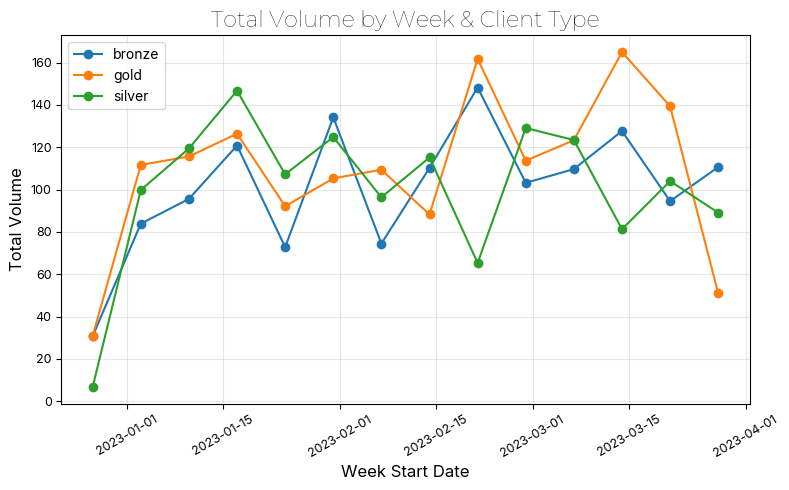

In [101]:
# Создаём график
plt.figure(figsize=(8,5))

# Группируем по неделям и типам клиентов
for CT, part in agg.groupby("client_type"):
    weekly = part.groupby("week_start_date")["total_volume"].sum().sort_index()
    plt.plot(weekly.index, weekly.values, marker="o", label=CT)

# Настраиваем свойства графика
plt.title(
    "Total Volume by Week & Client Type",
    fontname="Montserrat", fontsize=16, fontweight="bold"
) # Устанавливаем корпортавиный шрифт компании для заголовков
plt.xlabel("Week Start Date", fontname="Inter", fontsize=12) # Устанавливаем корпортавиный шрифт компании для набора текста
plt.ylabel("Total Volume", fontname="Inter", fontsize=12) # Устанавливаем корпортавиный шрифт компании для набора текста
plt.legend(prop={"family": "Inter", "size": 10}) # Устанавливаем корпортавиный шрифт компании для набора текста
plt.xticks(fontname="Inter", fontsize=9, rotation=30) # Устанавливаем корпортавиный шрифт компании для набора текста
plt.yticks(fontname="Inter", fontsize=9) # Устанавливаем корпортавиный шрифт компании для набора текста
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Сохраняем и отображаем график
plt.savefig("output/weekly_volume.png", dpi=300)
plt.show()

### Второй график будет отображать торговый объем каждого актива, который есть в БД 

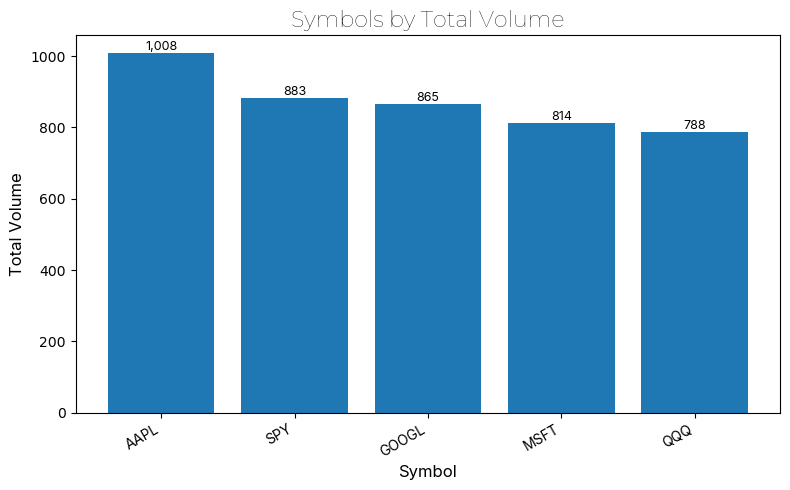

In [123]:
# Считаем суммарный объем по символам
symbols_total_volume = (
    agg.groupby("symbol")["total_volume"]
          .sum()
          .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))

# сохраняем bar-container в переменную
bars = plt.bar(symbols_total_volume.index, symbols_total_volume.values)

plt.title("Symbols by Total Volume", 
          fontname="Montserrat", fontsize=16, fontweight="bold") # Устанавливаем корпортавиный шрифт компании для заголовков
plt.xlabel("Symbol", fontname="Inter", fontsize=12) # Устанавливаем корпортавиный шрифт компании для набора текста
plt.ylabel("Total Volume", fontname="Inter", fontsize=12) # Устанавливаем корпортавиный шрифт компании для набора текста
plt.xticks(fontname="Inter", rotation=30, ha="right")

# Добавляем data labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # X = центр столбца
        height,                            # Y = вершина столбца
        f"{height:,.0f}",                  # подпись с форматированием числа
        ha="center", va="bottom",
        fontname="Inter", fontsize=9 # Устанавливаем корпортавиный шрифт компании для набора текста
    )

plt.tight_layout()

# Сохраняем и отображаем график
plt.savefig("output/symbols_total_volume.png", dpi=300)
plt.show()

### В конце получите и сохраните:

■ CSV/Excel-файл с топ-3 bronze-клиентами с наибольшим:

    ■ total_volume
    ■ total_pnl (опционально)
■ Результаты положите в output/top_clients.xlsx или .csv

In [93]:
bronze = agg[agg["client_type"]=="bronze"]
top_clients = (
    bronze.groupby("user_id")
          .agg(total_volume=("total_volume","sum"),
               total_pnl=("total_pnl","sum"))
          .sort_values("total_volume", ascending=False)
          .head(3)
)
top_clients.to_csv("output/top_clients.csv", index=True)